## Import libraries


In [77]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import math

### Import data

In [5]:
cwd = os.getcwd()
simp_path = 'raw_data/df.csv'
abs_path = os.path.abspath(os.path.join(cwd,'..',simp_path))
df_sarimax = pd.read_csv(abs_path)

In [6]:
df_sarimax.head()

,ticker,open,close,adj_close,low,high,volume,date,sector
0,AAPL,0.513393,0.513393,0.023186,0.513393,0.515625,117258400,1980-12-12,TECHNOLOGY
1,AAPL,0.488839,0.486607,0.021977,0.486607,0.488839,43971200,1980-12-15,TECHNOLOGY
2,AAPL,0.453125,0.450893,0.020364,0.450893,0.453125,26432000,1980-12-16,TECHNOLOGY
3,AAPL,0.462054,0.462054,0.020868,0.462054,0.464286,21610400,1980-12-17,TECHNOLOGY
4,AAPL,0.475446,0.475446,0.021473,0.475446,0.477679,18362400,1980-12-18,TECHNOLOGY


In [7]:
df_sarimax["spread"] = df_sarimax["open"] - df_sarimax["close"]
df_sarimax.head()

,ticker,open,close,adj_close,low,high,volume,date,sector,spread
0,AAPL,0.513393,0.513393,0.023186,0.513393,0.515625,117258400,1980-12-12,TECHNOLOGY,0.000000
1,AAPL,0.488839,0.486607,0.021977,0.486607,0.488839,43971200,1980-12-15,TECHNOLOGY,0.002232
2,AAPL,0.453125,0.450893,0.020364,0.450893,0.453125,26432000,1980-12-16,TECHNOLOGY,0.002232
3,AAPL,0.462054,0.462054,0.020868,0.462054,0.464286,21610400,1980-12-17,TECHNOLOGY,0.000000
4,AAPL,0.475446,0.475446,0.021473,0.475446,0.477679,18362400,1980-12-18,TECHNOLOGY,0.000000


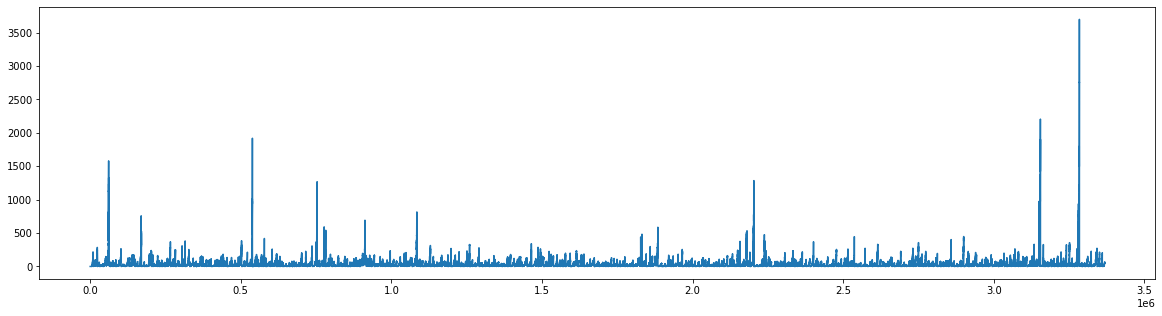

In [8]:
plt.figure(figsize=(20,5))
plt.plot(df_sarimax.adj_close);

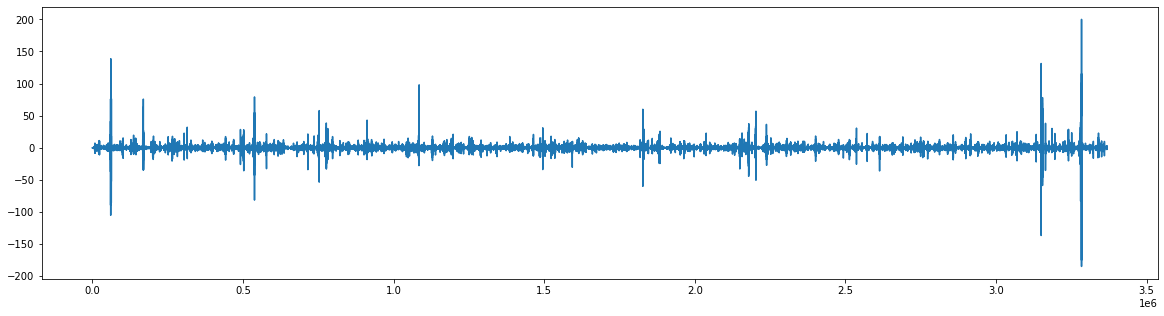

In [9]:
plt.figure(figsize=(20,5))
plt.plot(df_sarimax.spread);

In [7]:
#plt.plot(df_sarimax.adj_close);
#Ask Sandra later for the adj_close 

In [10]:
df_groupby = df_sarimax.groupby(["ticker"])["spread"].median()
df_groupby

ticker
A      -0.021460
AAL     0.020000
AAP     0.000000
AAPL    0.000000
ABBV   -0.079998
          ...   
YUM    -0.014378
ZBH    -0.050003
ZBRA    0.000000
ZION    0.000000
ZTS     0.010000
Name: spread, Length: 481, dtype: float64

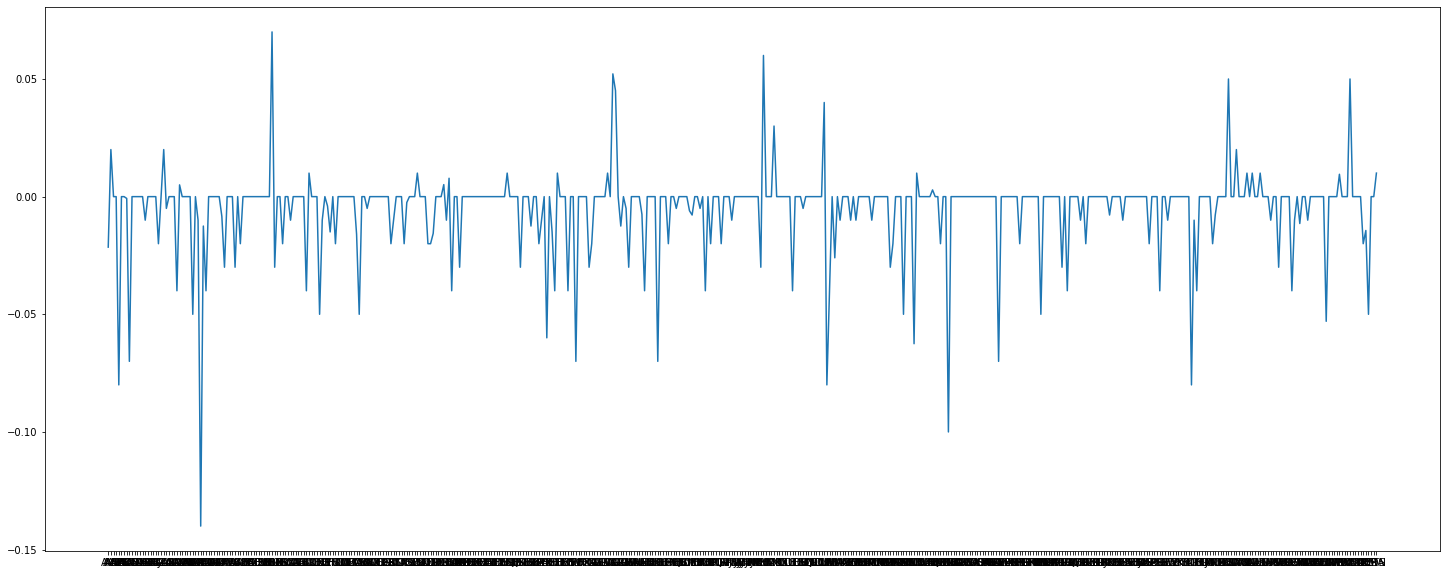

In [11]:
plt.figure(figsize=(25,10))
plt.plot(df_groupby);

In [10]:
#df_sarimax = df_sarimax[]
#pd.to_datetime(df["date"], format='%Y%m%d', errors='ignore')

In [12]:
df_sarimax["date"] = pd.to_datetime(df_sarimax["date"], infer_datetime_format=True)
df_sarimax.head()

,ticker,open,close,adj_close,low,high,volume,date,sector,spread
0,AAPL,0.513393,0.513393,0.023186,0.513393,0.515625,117258400,1980-12-12,TECHNOLOGY,0.000000
1,AAPL,0.488839,0.486607,0.021977,0.486607,0.488839,43971200,1980-12-15,TECHNOLOGY,0.002232
2,AAPL,0.453125,0.450893,0.020364,0.450893,0.453125,26432000,1980-12-16,TECHNOLOGY,0.002232
3,AAPL,0.462054,0.462054,0.020868,0.462054,0.464286,21610400,1980-12-17,TECHNOLOGY,0.000000
4,AAPL,0.475446,0.475446,0.021473,0.475446,0.477679,18362400,1980-12-18,TECHNOLOGY,0.000000


In [13]:
df_sarimax["date"].dtype

dtype('<M8[ns]')

In [14]:
df_sarimax.reset_index()
df_sarimax = df_sarimax.set_index(df_sarimax["date"])
df_sarimax = df_sarimax.drop("date", axis=1)

In [15]:
df_sarimax.head()

,ticker,open,close,adj_close,low,high,volume,sector,spread
date,,,,,,,,,
1980-12-12,AAPL,0.513393,0.513393,0.023186,0.513393,0.515625,117258400,TECHNOLOGY,0.000000
1980-12-15,AAPL,0.488839,0.486607,0.021977,0.486607,0.488839,43971200,TECHNOLOGY,0.002232
1980-12-16,AAPL,0.453125,0.450893,0.020364,0.450893,0.453125,26432000,TECHNOLOGY,0.002232
1980-12-17,AAPL,0.462054,0.462054,0.020868,0.462054,0.464286,21610400,TECHNOLOGY,0.000000
1980-12-18,AAPL,0.475446,0.475446,0.021473,0.475446,0.477679,18362400,TECHNOLOGY,0.000000


### Decomposition

In [16]:
df_sarimax = df_sarimax[(df_sarimax.index)>"1999-12-31"]
df_sarimax.head()

,ticker,open,close,adj_close,low,high,volume,sector,spread
date,,,,,,,,,
2000-01-03,AAPL,3.745536,3.997768,2.686497,3.631696,4.017857,133949200,TECHNOLOGY,-0.252232
2000-01-04,AAPL,3.866071,3.660714,2.459998,3.613839,3.950893,128094400,TECHNOLOGY,0.205357
2000-01-05,AAPL,3.705357,3.714286,2.495997,3.678571,3.948661,194580400,TECHNOLOGY,-0.008929
2000-01-06,AAPL,3.790179,3.392857,2.279998,3.392857,3.821429,191993200,TECHNOLOGY,0.397321
2000-01-07,AAPL,3.446429,3.553571,2.387998,3.410714,3.607143,115183600,TECHNOLOGY,-0.107143


In [17]:
df_telekom = df_sarimax[df_sarimax["ticker"]== "T"]
df_telekom.head()

,ticker,open,close,adj_close,low,high,volume,sector,spread
date,,,,,,,,,
2000-01-03,T,48.5625,47.0000,19.225044,46.6250,49.00,5791900,PUBLIC UTILITIES,1.5625
2000-01-04,T,47.0625,44.2500,18.100174,43.5000,47.75,7173600,PUBLIC UTILITIES,2.8125
2000-01-05,T,45.0000,44.9375,18.381397,44.4375,45.25,9090000,PUBLIC UTILITIES,0.0625
2000-01-06,T,44.5625,43.7500,17.993273,43.1250,45.00,7153600,PUBLIC UTILITIES,0.8125
2000-01-07,T,44.5625,44.1250,18.147497,43.3750,44.75,5885600,PUBLIC UTILITIES,0.4375


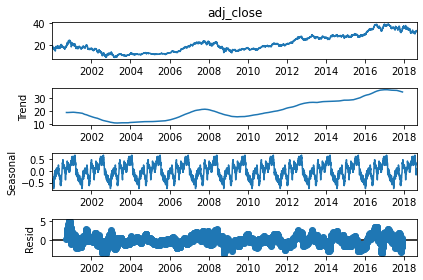

In [18]:
# additive Decomposition (y = Trend * Seasonal * Residuals)
result_add_T = seasonal_decompose(df_telekom['adj_close'], model='additive', period=365)
result_add_T.plot();

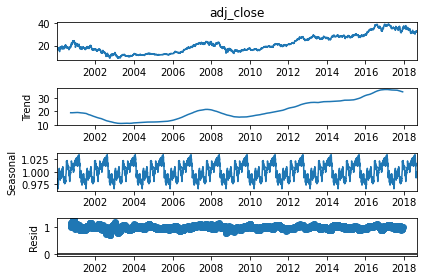

In [39]:
#Multiplicative Decomposition
result_mult_T = seasonal_decompose(df_telekom['adj_close'], model='multiplicative', period=365)
result_mult_T.plot();

### Check for stationality

In [1]:
# Plot the residuals with "result_add.resid" to decide
#f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
#ax1.plot(result_add.resid); ax1.set_title("Additive model residuals")
#ax2.plot(result_mul.resid); ax2.set_title("Multiplicative model residuals");

In [55]:
result_mult_T.__dict__.keys()

dict_keys(['_seasonal', '_trend', '_weights', '_resid', '_observed'])

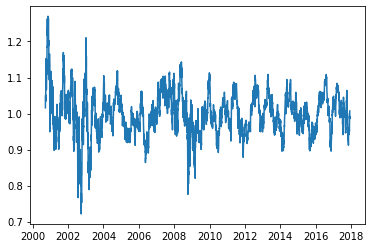

In [67]:
#Plot the residuals
plt.plot(result_mult_T._resid);

In [59]:
#Multiplicative result 
result_observed=result_mult_T.resid.dropna()

In [60]:
adfuller(result_observed)[1]

1.3512767530810397e-11

In [61]:
#additive result
result_observed_sum = result_add_T.resid.dropna()

In [62]:
adfuller(result_observed_sum)[1]

1.0610027148037372e-10

In [65]:
print("Multiplicative p-value: ", adfuller(result_observed)[1])

Multiplicative p-value:  1.3512767530810397e-11


In [66]:
print("Additive p-value: ", adfuller(result_observed_sum)[1])

Additive p-value:  1.0610027148037372e-10


### Autocorrelation

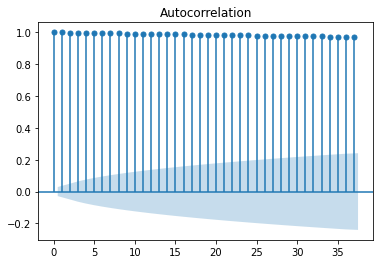

In [26]:
y = df_telekom.adj_close
#plot_acf(df_telekom["adj_close"], lags=50)
plot_acf(y);

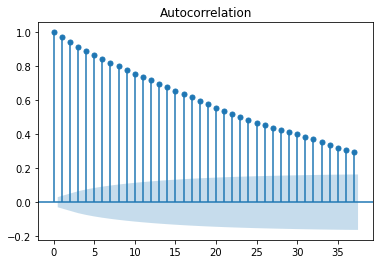

In [71]:
#plot the residuals with acf 
plot_acf(result_observed);

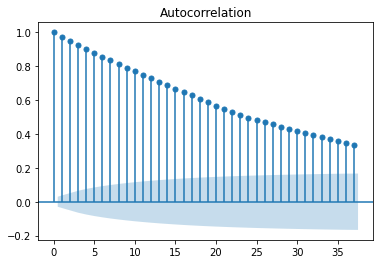

In [72]:
plot_acf(result_observed_sum);

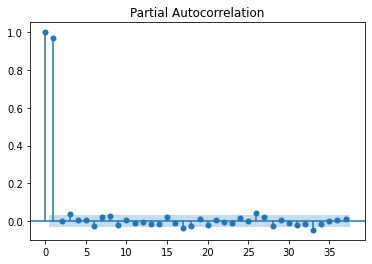

In [73]:
plot_pacf(result_observed);

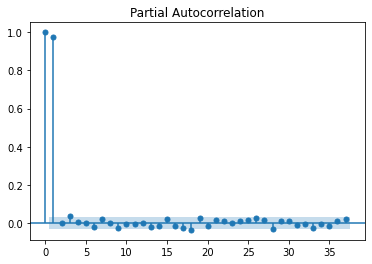

In [74]:
plot_pacf(result_observed_sum);

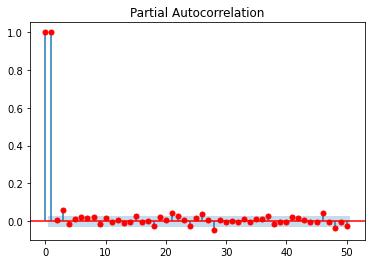

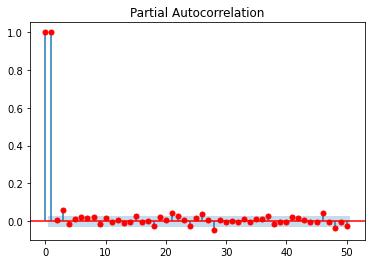

In [30]:
plot_pacf(df_telekom.adj_close, lags=50, c='r')
#plt.show()

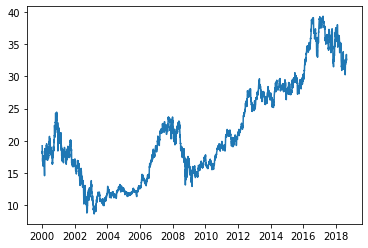

In [33]:
#Plot telekom stock
plt.plot(df_telekom.adj_close);

## Building the SARIMA model

In [81]:
#I make the log to run the SARIMA Model
df_telekom.loc[:,"log_adj_close"] = df_telekom["adj_close"].apply(lambda x: math.log(x))

/home/luis/.pyenv/versions/3.8.6/envs/stock_prices_predictions/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [85]:
df_telekom.head()

,ticker,open,close,adj_close,low,high,volume,sector,spread,log_adj_close
date,,,,,,,,,,
2000-01-03,T,48.5625,47.0000,19.225044,46.6250,49.00,5791900,PUBLIC UTILITIES,1.5625,2.956214
2000-01-04,T,47.0625,44.2500,18.100174,43.5000,47.75,7173600,PUBLIC UTILITIES,2.8125,2.895922
2000-01-05,T,45.0000,44.9375,18.381397,44.4375,45.25,9090000,PUBLIC UTILITIES,0.0625,2.911339
2000-01-06,T,44.5625,43.7500,17.993273,43.1250,45.00,7153600,PUBLIC UTILITIES,0.8125,2.889998
2000-01-07,T,44.5625,44.1250,18.147497,43.3750,44.75,5885600,PUBLIC UTILITIES,0.4375,2.898533


In [43]:
#convert again to exponential form to make the predictions
#df[‘log_adj_close’] = df[‘adj_close’].map(lambda x: log(x))
#exp(x)

In [87]:
model = pm.auto_arima(df_telekom["log_adj_close"],
                      m=7, # frequency of series. Important to choose manually
                      seasonal=True,
                      stepwise=True,  # only check most interesting combination. False will take way longer.
                      start_p=0, max_p=2,
                      start_d=0, max_d=1,
                      start_q=0, max_q=2,
                      start_P=0, max_P=2,
                      start_D=0, max_D=2,
                      start_Q=0, max_Q=2,
                      njobs=-1, trace=True, error_action="ignore",  suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-25342.431, Time=0.67 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-25345.360, Time=8.27 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-25345.601, Time=6.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-25344.204, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-25340.482, Time=2.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-25344.538, Time=25.71 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-25345.581, Time=35.92 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-25345.363, Time=5.29 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-25343.727, Time=18.34 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-25347.544, Time=16.94 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-25346.482, Time=8.31 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-25347.530, Time=10.93 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-25347.306, Time=4.40 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-25345.675, Time=11.72 sec

In [ ]:
#Best parameters to run my model: 
#ARIMA(0,1,0)(0,0,1)[7] 

## Making predictions

### Split the data (test/set)

In [88]:
#Split the data in train / test 
df_telekom_train = df_telekom[:"2014"]
df_telekom_test = df_telekom["2015":]
print(df_telekom_train.shape)
print(df_telekom_test.shape)

(3773, 10)
(919, 10)


In [97]:
df_telekom_test.shape

(919, 10)

In [98]:
df_telekom_train.shape

(3773, 10)

In [99]:
df_telekom_train = pd.DataFrame(df_telekom_train)
df_telekom_test = pd.DataFrame(df_telekom_test)

### First Prediction :)  

In [107]:
#Forecast
n_periods = len(df_telekom_test["log_adj_close"])
central, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_telekom_test.index 

#Make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

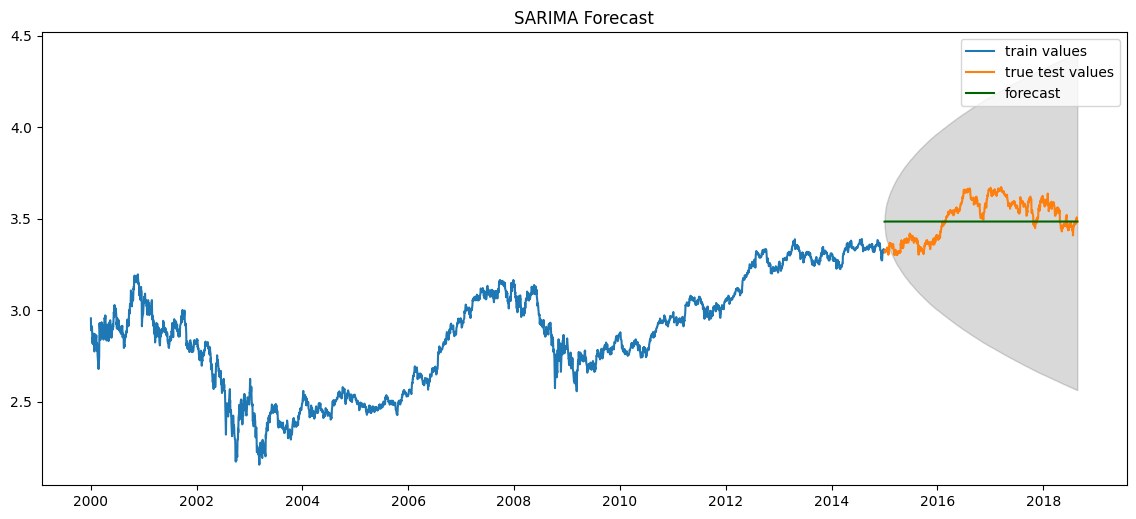

In [108]:
#Plotting my predictions against reality
plt.figure(figsize=(14,6), dpi=100)
plt.plot(df_telekom_train["log_adj_close"], label="train values")
plt.plot(df_telekom_test["log_adj_close"], label="true test values")
plt.plot(central, color="darkgreen", label="forecast")
plt.fill_between(lower.index, 
                lower,
                upper,
                color="k", alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()